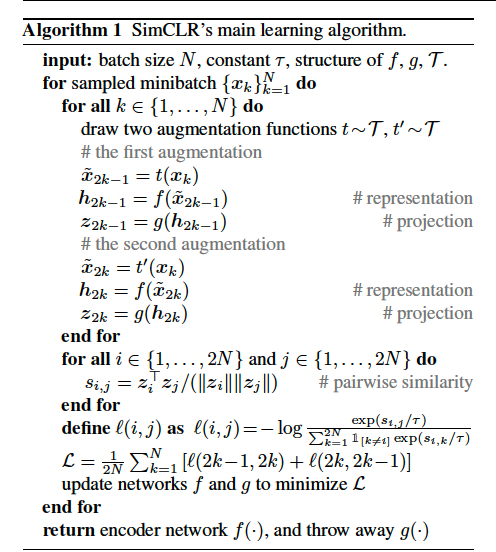

In [1]:
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import torch as tr
import torchvision
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# simclr loss

In [3]:
import torch
import torch.nn.functional as F

def simclr_loss(z_i: torch.Tensor, z_j: torch.Tensor, temperature: float = 0.5) -> torch.Tensor:
    """
    Computes the simCLR loss function for a batch of paired feature vectors.

    Args:
        z_i (torch.Tensor): A tensor of shape (N, D) representing the feature vectors of the first views.
        z_j (torch.Tensor): A tensor of shape (N, D) representing the feature vectors of the second views.
        temperature (float): The temperature parameter for the softmax operation. Default: 0.5.

    Returns:
        torch.Tensor: A scalar tensor representing the simCLR loss for the given batch of paired feature vectors.

    Raises:
        ValueError: If z_i and z_j do not have the same shape or if the shape of z_i or z_j is not (N, D).
    """
    # Normalize the feature vectors
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)

    # Concatenate the feature vectors and create the targets
    z = torch.cat([z_i, z_j], dim=0)
    targets = torch.arange(z.size(0)).to(z.device)
    masks = F.one_hot(targets, num_classes=z.size(0))

    # Compute the similarities between all pairs of feature vectors
    similarities = torch.matmul(z, z.t()) / temperature

    # Set the diagonal elements (i.e., the similarities between each feature vector and itself) to negative infinity
    mask = masks.float().neg()
    similarities = similarities.masked_fill(mask == 1, float('-inf'))

    # Compute the numerator and denominator of the loss function
    numerator = torch.exp(similarities)
    denominator = numerator.sum(dim=1, keepdim=True)

    # Compute the loss function
    loss = -torch.log(numerator / denominator).mean()

    return loss


# data loading

In [4]:
batch_size_train = 16
batch_size_test = 16

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# architecture

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x



# training

In [6]:
# init 
encoder = Net()
mlp = MLP()

In [7]:
# one iteration over dataset
print(f"N={len(train_loader)}")
for bn,(x,y) in enumerate(train_loader):
  xi = x_i = x
  xj = x_j =  torchvision.transforms.functional.resized_crop(
    x,
    top=8,
    left=8,
    height=12,
    width=12,
    size=(28,28)
  )
  hi = encoder(xi)
  hj = encoder(xj)
  zi = mlp(hi)
  zj = mlp(hj)
  if bn >= 20:
    break
    
  l = simclr_loss(zi,zj)

N=3750


/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# data visualization

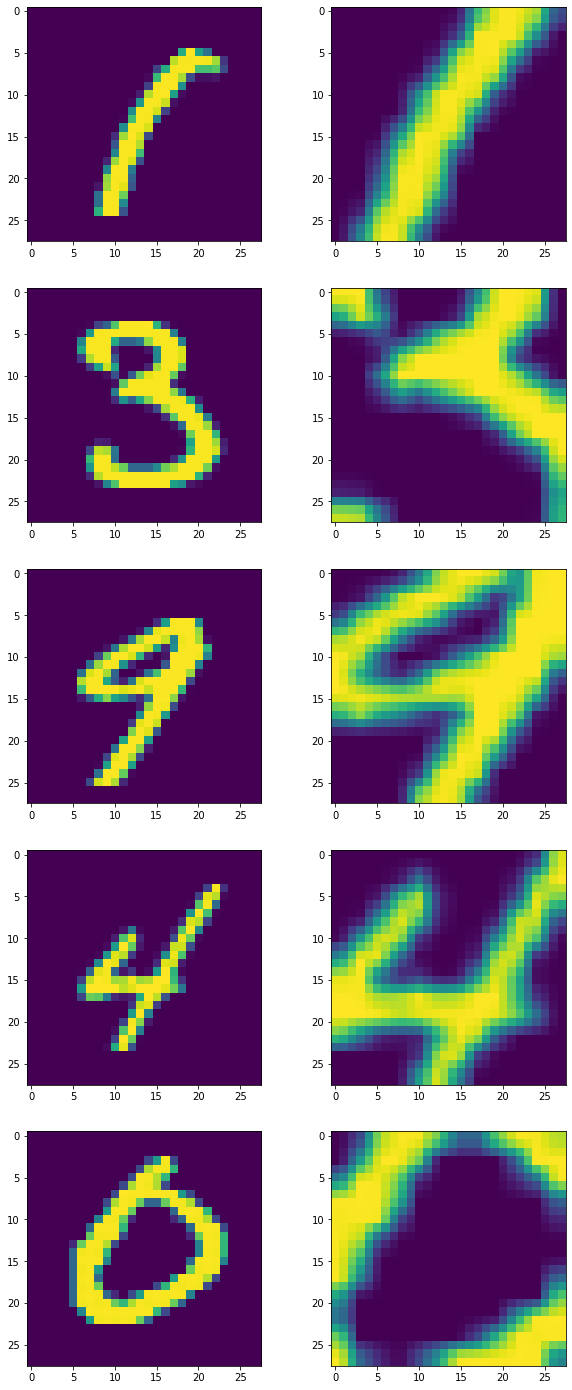

In [8]:
def visualize_batch(x_i,x_j):
  N,C,H,W = x_i.shape
  Nplt = np.min([5,N])
  fg,axar = plt.subplots(Nplt,2,figsize=(10,5*Nplt))
  for ix in range(Nplt):
    ax1 = axar[ix,0]
    ax2 = axar[ix,1]
    ax1.imshow(x_i[ix,0])
    ax2.imshow(x_j[ix,0])
  return None
visualize_batch(x_i,x_j)

In [9]:
# for x,y in train_loader
train_loader